<a href="https://colab.research.google.com/github/aliakbarbadri/mountain-car-v0/blob/master/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Show video

In [ ]:
!apt-get install python-opengl -y
!apt install xvfb -y
!pip install pyvirtualdisplay
!pip install pyglet

In [3]:
import matplotlib.animation
from IPython.display import HTML
from IPython.display import display as ipy_disp
import tensorflow as tf
from tensorflow import keras
from tqdm.auto import tqdm
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import gym
import random

In [4]:
%matplotlib inline

def get_screen():
  global display
  try:
    display.stop()
  except:
    pass
  from pyvirtualdisplay import Display
  display = Display(visible=0, size=(1400, 900))
  display.start()

get_screen()

def show(frames):
  plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi = 72)
  patch = plt.imshow(frames[0])
  plt.axis('off')
  animate = lambda i: patch.set_data(frames[i])
  ani = matplotlib.animation.FuncAnimation(plt.gcf(), animate, frames=len(frames), interval = 50)
  html = HTML(ani.to_html5_video())
  ipy_disp(html, display_id='1')
  plt.close()

In [5]:
env = gym.make('MountainCar-v0')

# 1 Random Model

In [ ]:
def play(N, render=True):
    env = gym.make('MountainCar-v0')
    all_rewards = []
    all_frames = []
    
    for n in range(N):
      observation = env.reset()
      episode_frames = []
      episode_reward = 0
      done = False
      while not done and len(episode_frames) < 1000:
        episode_frames.append(env.render(mode='rgb_array') if render else [])
        # action = get_action(observation, mode='test')
        # observation, reward, done, _ = self.env.step(action)
        observation, reward, done, _ = env.step(env.action_space.sample())
        episode_reward += reward
      all_rewards.append(episode_reward)
      all_frames.append(episode_frames)
      print('Episode {} finished in {} steps and got {} reward in total!!!'
                .format(n+1, len(episode_frames), episode_reward))
    return all_rewards, all_frames

In [ ]:
all_rewards, all_frames = play(20)

Episode 1 finished in 200 steps and got -200.0 reward in total!!!
Episode 2 finished in 200 steps and got -200.0 reward in total!!!
Episode 3 finished in 200 steps and got -200.0 reward in total!!!
Episode 4 finished in 200 steps and got -200.0 reward in total!!!
Episode 5 finished in 200 steps and got -200.0 reward in total!!!
Episode 6 finished in 200 steps and got -200.0 reward in total!!!
Episode 7 finished in 200 steps and got -200.0 reward in total!!!
Episode 8 finished in 200 steps and got -200.0 reward in total!!!
Episode 9 finished in 200 steps and got -200.0 reward in total!!!
Episode 10 finished in 200 steps and got -200.0 reward in total!!!
Episode 11 finished in 200 steps and got -200.0 reward in total!!!
Episode 12 finished in 200 steps and got -200.0 reward in total!!!
Episode 13 finished in 200 steps and got -200.0 reward in total!!!
Episode 14 finished in 200 steps and got -200.0 reward in total!!!
Episode 15 finished in 200 steps and got -200.0 reward in total!!!
Epis

In [ ]:
show(all_frames[5])

In [ ]:
len(all_frames),len(all_frames[0]),all_frames[0][0].shape

(20, 200, (400, 600, 3))

# 2 random model Model

In [7]:
env.seed(42)
obs = env.reset()
obs
# obs = array([position, velocity])
# position = [-1.2 , 0.6]
# velocity = [-0.07,	0.07]

array([-0.52517132,  0.        ])

In [8]:
img = env.render(mode="rgb_array")
img.shape

(400, 600, 3)

In [9]:
def plot_environment(env, figsize=(5,4)):
    plt.figure(figsize=figsize)
    img = env.render(mode="rgb_array")
    plt.imshow(img)
    plt.axis("off")
    return img

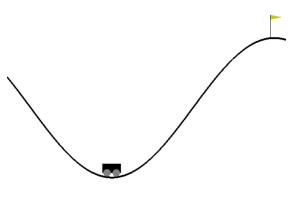

In [10]:
plot_environment(env)
plt.show()

In [11]:
env.action_space
# 0	push left
# 1	no push
# 2	push right

Discrete(3)

In [16]:
action = 0
obs, reward, done, info = env.step(action)
obs, reward, done, info

(array([-0.52812853, -0.001969  ]), -1.0, False, {})

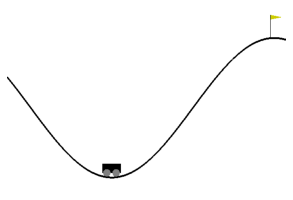

In [15]:
plot_environment(env)
plt.show()

In [18]:
env.seed(42)

frames = []

obs = env.reset()
for step in range(200):
    img = env.render(mode="rgb_array")
    frames.append(img)
    action = env.action_space.sample()
    obs, reward, done, info = env.step(action)
    if done:
        break

In [21]:
import matplotlib.animation as animation
mpl.rc('animation', html='jshtml')

In [22]:
def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames, repeat=False, interval=40):
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    anim = animation.FuncAnimation(
        fig, update_scene, fargs=(frames, patch),
        frames=len(frames), repeat=repeat, interval=interval)
    plt.close()
    return anim

In [23]:
plot_animation(frames)

# NN Models

In [26]:
env.observation_space.shape[0], env.action_space

(2, Discrete(3))

In [ ]:
def render_policy_net(model, n_max_steps=200, seed=42):
    frames = []
    env = gym.make('MountainCar-v0')
    env.seed(seed)
    np.random.seed(seed)
    obs = env.reset()
    for step in range(n_max_steps):
        frames.append(env.render(mode="rgb_array"))
        left_proba = model.predict(obs.reshape(1, -1))
        action = int(np.random.rand() > left_proba)
        obs, reward, done, info = env.step(action)
        if done:
            break
    env.close()
    return frames

In [ ]:
def play_one_step(env, obs, model, loss_fn):
    with tf.GradientTape() as tape:
        left_proba = model(obs[np.newaxis])
        action = (tf.random.uniform([1, 1]) > left_proba)
        y_target = tf.constant([[1.]]) - tf.cast(action, tf.float32)
        loss = tf.reduce_mean(loss_fn(y_target, left_proba))
    grads = tape.gradient(loss, model.trainable_variables)
    obs, reward, done, info = env.step(int(action[0, 0].numpy()))
    return obs, reward, done, grads

In [ ]:
def play_multiple_episodes(env, n_episodes, n_max_steps, model, loss_fn):
    all_rewards = []
    all_grads = []
    for episode in range(n_episodes):
        current_rewards = []
        current_grads = []
        obs = env.reset()
        for step in range(n_max_steps):
            obs, reward, done, grads = play_one_step(env, obs, model, loss_fn)
            current_rewards.append(reward)
            current_grads.append(grads)
            if done:
                break
        all_rewards.append(current_rewards)
        all_grads.append(current_grads)
    return all_rewards, all_grads

In [ ]:
def discount_rewards(rewards, discount_rate):
    discounted = np.array(rewards)
    for step in range(len(rewards) - 2, -1, -1):
        discounted[step] += discounted[step + 1] * discount_rate
    return discounted

def discount_and_normalize_rewards(all_rewards, discount_rate):
    all_discounted_rewards = [discount_rewards(rewards, discount_rate)
                              for rewards in all_rewards]
    flat_rewards = np.concatenate(all_discounted_rewards)
    reward_mean = flat_rewards.mean()
    reward_std = flat_rewards.std()
    return [(discounted_rewards - reward_mean) / reward_std
            for discounted_rewards in all_discounted_rewards]

In [ ]:
n_iterations = 150
n_episodes_per_update = 10
n_max_steps = 200
discount_rate = 0.95

In [ ]:
optimizer = keras.optimizers.Adam(lr=0.01)
loss_fn = keras.losses.binary_crossentropy

## MLP

In [ ]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)
n_inputs = env.observation_space.shape[0]

model = keras.models.Sequential([
    keras.layers.Dense(5, activation="elu", input_shape=[n_inputs]),
    keras.layers.Dense(1, activation="sigmoid"),
])

## CNN

## Training

In [ ]:
env = gym.make('MountainCar-v0')
env.seed(42);

for iteration in range(n_iterations):
    all_rewards, all_grads = play_multiple_episodes(
        env, n_episodes_per_update, n_max_steps, model, loss_fn)
    total_rewards = sum(map(sum, all_rewards))                     # Not shown in the book
    print("\rIteration: {}, mean rewards: {:.1f}".format(          # Not shown
        iteration, total_rewards / n_episodes_per_update), end="") # Not shown
    all_final_rewards = discount_and_normalize_rewards(all_rewards,
                                                       discount_rate)
    all_mean_grads = []
    for var_index in range(len(model.trainable_variables)):
        mean_grads = tf.reduce_mean(
            [final_reward * all_grads[episode_index][step][var_index]
             for episode_index, final_rewards in enumerate(all_final_rewards)
                 for step, final_reward in enumerate(final_rewards)], axis=0)
        all_mean_grads.append(mean_grads)
    optimizer.apply_gradients(zip(all_mean_grads, model.trainable_variables))

env.close()

In [ ]:
frames = render_policy_net(model)
plot_animation(frames)